# SIR model

A simple mathematical description of the spread of a disease in a population was first proposed by Kermack and McKendrick [Proc. R. Soc. A, 115, 772 (1927)](https://royalsocietypublishing.org/doi/10.1098/rspa.1927.0118).

Assumptions of the model: 
- we have a fixed size of a population (N), which means no one dies or is born in the time ocurse of the analysis,
- people who were infected (with β describing the effective contact rate) and recovered (with a recovery rate γ) gain immunity and can not get infected anymore, hence, population is divided into three categories:
  - S - susceptible,
  - I - infected,
  - R - recovered.

The differential equations describing this model:
$$\begin{align}
\frac{d\mathrm{S}}{dt}  &= −β\frac{SI}{N} \\
\frac{d\mathrm{I}}{dt}  &= β\frac{SI}{N}−γI \\
\frac{d\mathrm{R}}{dt}  &= γI \\
\end{align}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Task 1

Compute how many people will be infected with the disease after the period of 20 days, with new infections rate β set to 2 and the recovery rate γ set to 0.1. What do you observe?

In [2]:
from modelbase.ode import Model, Simulator

In [3]:
def infection(S, I, N, beta):
    return beta * S * I / N


def turnover(I, gamma):
    return gamma * I


def total_population(S, I, R):
    return S + I + R


parameters = {
    "beta": 2,  # new infections caused by one infection
    "gamma": 0.1,  # turnover rate of infected (death or recovery)
}

m = Model()
m.add_parameters(parameters)
m.add_compounds(("S", "I", "R"))
m.add_algebraic_module(
    module_name="N",
    function=total_population,
    compounds=["S", "I", "R"],
    derived_compounds=["N"],
)
m.add_reaction(
    rate_name="infection",
    function=infection,
    stoichiometry={"S": -1, "I": 1},
    modifiers=["I", "N"],
    parameters=["beta"],
)
m.add_reaction(
    rate_name="turnover",
    function=turnover,
    stoichiometry={"I": -1, "R": 1},
    parameters=["gamma"],
)

In [4]:
# Using one of the available formats to view the stoichiomteric matrix check your model.
m.get_stoichiometric_df()

infection  turnover
I        1.0      -1.0
R        0.0       1.0
S       -1.0       0.0

(<Figure size 720x504 with 1 Axes>,
 <AxesSubplot:xlabel='days', ylabel='population size'>)

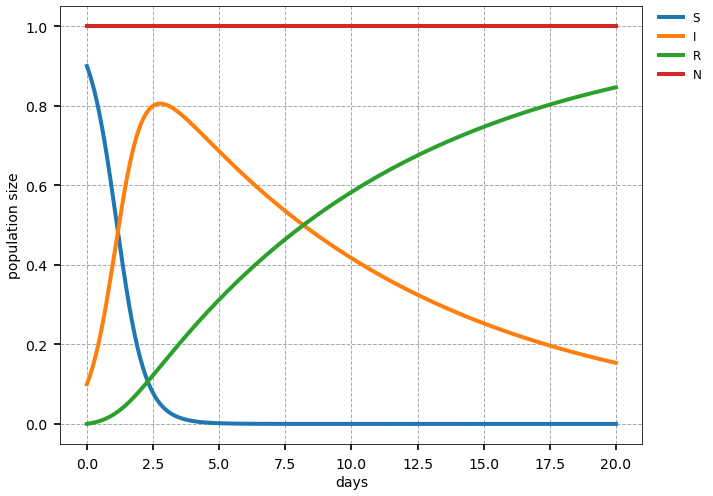

In [5]:
# Simulate system for 20 days and plot the results
s = Simulator(m)
s.initialise({"S": 0.9, "I": 0.1, "R": 0})
s.simulate(20)
s.plot_all(xlabel="days", ylabel="population size")

## Task 2

Using ```update_parameter``` function vary the infection and recovery rate constants and investigate the effect they have on the system.

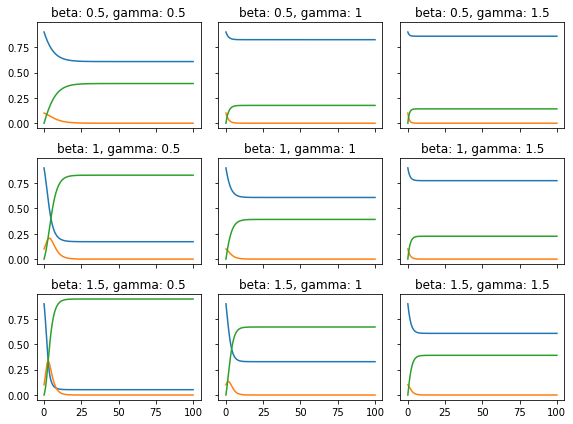

In [6]:
gammas = [0.5, 1, 1.5]
betas = [0.5, 1, 1.5]

fig, axs = plt.subplots(3, 3, figsize=(8, 6), sharex=True, sharey=True)

for i, beta in enumerate(betas):
    for j, gamma in enumerate(gammas):
        s.clear_results()
        s.update_parameter("beta", beta)
        s.update_parameter("gamma", gamma)
        s.simulate(100)
        axs[i, j].plot(s.time[0], s.results[0])
        axs[i, j].set_title(f"beta: {beta}, gamma: {gamma}")
fig.tight_layout()

## Task 3
Improve the model description by allowing dynamic size of the population (SIR with vital dynamics) by including both birth rate and death rate from the infection.

New assumptions:
- include birth rate $\alpha$ set to 0.1,
- every newborn is healthy but automatically susceptible to the disease,
- infected can recover but also die with a death rate $\delta$ set to 0.2, hence new subpopulation is created, differentating between the recovered and removed,
- the population size is 20, with one person infected.

The differential equations describing this model:
$$\begin{align}
\frac{d\mathrm{S}}{dt}  &= \alpha N−β\frac{SI}{N} \\
\frac{d\mathrm{I}}{dt}  &= β\frac{SI}{N}−γI −\delta I\\
\frac{d\mathrm{R}}{dt}  &= γI \\
\frac{d\mathrm{D}}{dt}  &= \delta I
\end{align}$$

Investigate the spread of the disease over the period of 100 days.

In [7]:
# define the y0
y0 = {"S": 19, "I": 1, "R": 0, "D": 0}

In [8]:
# define new reactions descirbing birth and death
def births(population, birth_rate):
    return birth_rate * population


def deaths(population, death_rate):
    return death_rate * population

In [9]:
# add new subpopulation
m.add_compound("D")

In [10]:
# add the new parameters to the existing model
parameters = {
    "birth_rate": 0.1,
    "death_rate": 0.2,
}

m.add_parameters(parameters)

In [11]:
# add the two reactions and consider which subpopulations will they effect
m.add_reaction(
    rate_name="births",
    function=births,
    stoichiometry={"S": 1},
    modifiers=["S"],
    parameters=["birth_rate"],
)
m.add_reaction(
    rate_name="death_i",
    function=deaths,
    stoichiometry={"I": -1, "D": 1},
    parameters=["death_rate"],
)

In [12]:
m.get_stoichiometric_df()

births  death_i  infection  turnover
D     0.0      1.0        0.0       0.0
I     0.0     -1.0        1.0      -1.0
R     0.0      0.0        0.0       1.0
S     1.0      0.0       -1.0       0.0

(<Figure size 720x504 with 1 Axes>,
 <AxesSubplot:xlabel='days', ylabel='population size'>)

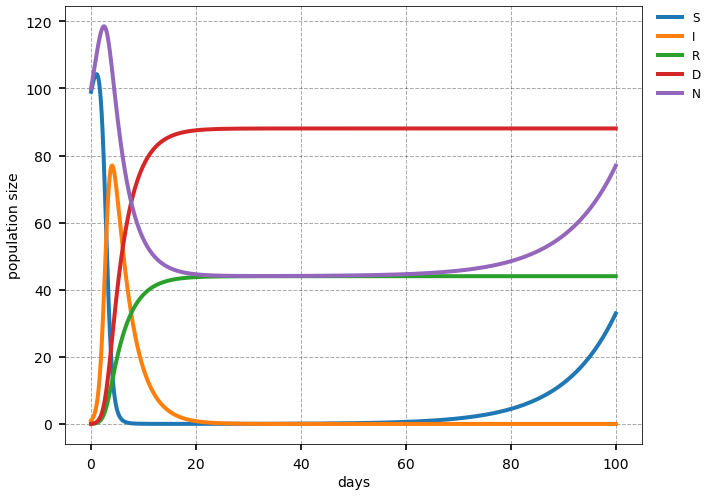

In [15]:
s = Simulator(m)
s.update_parameters(
    {
        "beta": 2,  # new infections caused by one infection
        "gamma": 0.1,  # turnover rate of infected (death or recovery)
    }
)
s.initialise({"S": 99, "I": 1.0, "R": 0.0, "D": 0.0})
s.simulate(100)
s.plot_all(xlabel="days", ylabel="population size")

# Task 4
Make the virus more deadly. Which parameters would you change? Investigate the effect on the population dyunamics over the time of 1000 days.

In [54]:
# change the dynamics of a specific reaction and use the ```update_reaction```